# Restricted 3-Body Integration of Asteroid Orbits
- Author: Kai Stewart
- Semester: Spring 2020

In [1]:
import time
import random
import numpy as np
from scipy.integrate import RK45 as ODE45
from scipy.integrate import solve_ivp as IVP
import matplotlib.pyplot as plt
%matplotlib inline

### Set a random number seed - either for reproducability or variability within the runs

In [2]:
random.seed(time.time())

### Define values of objects and constants
- N is the number of asteroids. An increase in this value causes a linear increase in the runtime
- G is the universal gravitational constant converted to units of: $AU^3 / (kg \cdot Yr^2)$
- M_S is the mass of the Sun in kg
- AU is the value of one astronimical unit in meters -- the mean distance from the center of the sun to the center of the earth.
- M_J is the mass of Jupiter in kg
- R_J is the distance of Jupiter from the Sun in AU
- V_J is the orbital velocity of Jupiter converted to AU/Yr

In [3]:
N = 1
G = 6.67e-11 * ( (365*86400)**2 / (1.5e11)**3 )
M_S = 1.99e30
AU = 1.5e11
M_J = 1.898e27
R_J = 7.41e11 
V_J = 13720 * 365 * 86400

### Use the center-of-mass definition for the Sun-Jupiter system to compute x-y-coordinates
- Setting the center of the sun as the center of the coordinate system, the center-of-mass follows as the product of each mass with that objects corresponding distance from the center of the coordinate system, divided by the sum of all the object masses.

$\text{CoM}_{Sun-Jupiter} = \frac{ M_S\cdot0 + M_J\cdot R_J}{M_S + R_J}$

In [4]:
x0_S = -(M_J * R_J)/(M_S + M_J) # [AU]
y0_S = 0
vx0_S = 0
vy0_S = -(1/M_S)*(M_S * V_J) #[AU/Yr]

### Define the initial state vector of the sun and jupiter, assuming that both objects are co-planar

In [5]:
s0 = [vx0_S, vy0_S, x0_S, y0_S, 0, V_J, R_J, 0]

### Set the number of years (range) over which to integrate

In [6]:
t = 1000; t_span = [0, t]

### Function definitions

In [7]:
def random_float(low, high):
    '''
        Function that returns a random floating point number in the range [low, high] inclusive.
        Could use Numpy to do this, but it's more interesting to write my own function.
        Args:
            - low (float): lower bound of desired random float.
            - high (float): upper bound of desired random float.
        Returns:
            - random floating point number
    '''
    return random.random()*(high-low) + low

In [8]:
def D_grav(t, s_vec, m_arr, G):
    '''
        Function that computes the derivatives of an N-Body Gravity problem. 
        Will be passed to the ODE45 algorithm as an argument.
        Args:
            - t (float): starting time for the numerical integrator. Assumed to begin at one
                         and integrate forwards in time. Unless you're Doc Martin, of course.
            - s_vec (array): system intitial state vector
                - This array needs to have the form: [V_x0, V_y0, X_0, Y_0] repeated for each object.
                  The algorithm assumes that every four entries within the array correspond to a single
                  object, so the entries need to align accordingly.
            - m_arr (array): Masses of the Sun, Jupiter, and a single asteroid. 
                - The array needs to have the form: [M_S, M_J, M_a].
                  The algorithm assumes that the mass information is located at the corresponding
                  indices in the array.
        Returns:
            - dsdt (Numpy array): Array of derivative values for each of the n-asteroids in the simulation.
                                  The array has the form (n,): 
                                  [dvx/dt_0, dvy/dt_0, dx/dt_0, dy/dt_0, ... , dvx/dt_N, dvy/dt_N, dx/dt_N, dy/dt_N]
    '''
    # Set the range of the for-loops to the length of the mass array
    N = len(m_arr)
    assert N==3, "Mass array must be of length 3 only!"
    
    # Set the size of the storage arrays to N*4 in order to accomodate
    # vx, vy, x, y data for each of the three objects
    M = N*4
    
    # Arrays to track the position computations
    # - x-velocity - # - y-velocity - # - x-coords - # - y-coords - #
    vx = np.zeros(M); vy = np.zeros(M); x = np.zeros(M); y = np.zeros(M)

    # Arrays to track the derivative computations
    # --- dvx/dt --- # ----- dvy/dt ----- # ----- dx/dt ----- # --- dy/dt --- #
    dvx = np.zeros(M); dvy = np.zeros(M); dx = np.zeros(M); dy = np.zeros(M)
    
    # Again, this loop assumes that every four entries in the state vector
    # correspond to a single object. This algorithm will fail if the state
    # vector is not constructed properly.
    for i in range(0, N*4, 4):
        vx[i] = s_vec[i]
        vy[i] = s_vec[i+1]
        x[i]  = s_vec[i+2]
        y[i]  = s_vec[i+3]

        # Position derivates are given by the current velocity
        dx[i] = vx[i]
        dy[i] = vy[i]
        
        # Find the total force acting on an asteroid from the Sun and Jupiter.
        ## Set initial acceleration to zero and sum over the force contributions
        ## from all of the masses (Sun, Jupiter, Asteroid)
        a_x = 0; a_y = 0
        for k in range(N):
            if i != k:
                # Find the separation distance
                r_sep = (x[i] - x[k])**2 + (y[i] - y[k])**2
                # Compute the x-y components of the acceleration of the ith mass due to the kth mass
                a_x = a_x + (G * m_arr[k] * (x[k] - x[i])) / (r_sep**(3/2))
                a_y = a_y + (G * m_arr[k] * (y[k] - y[i])) / (r_sep**(3/2))
        # Store the computed acceleration values
        dvx[i] = a_x
        dvy[i] = a_y
    
    # Create a single vector from all of the computed values for the ODE45 algorithm
    dsdt = np.zeros(M)

    for i in range(0, N, 4):
        dsdt[i]   = dvx[i]
        dsdt[i+1] = dvy[i+1]
        dsdt[i+2] = x[i+2]
        dsdt[i+3] = y[i+3]
    
    return dsdt

In [9]:
def make_asteroids(N,G,M_S):
    '''
        - This function generates randomized arrays corresponding to asteroid masses, their position components
          in cartesian coordinates [AU], and velocity components [AU/Yr]
        Args:
            - N (int): number of asteroids to generate
            - G (float): gravitational constant
            - M_S (float): mass of the sun used to generate random asteroid velocities
        Returns:
            - state_vector (dict) containing:
                - a_masses (Numpy Array): array of N masses, each randomly distributed between 10^10 and 10^20 kg
                - a_x (Numpy Array): array of randomly distributed x-coordinates for N asteroids
                - a_y (Numpy Array): array of randomly distributed y-coordinates for N asteroids
                - v_x (Numpy Array): array of randomly distributed x-velocities for N asteroids
                - v_y (Numpy Array): array of randomly distributed y-velocities for N asteroids
    '''
    # Initialize the arrays
    # ----- Masses ----- ## -- x-coords -- ## -- y-coords -- ## -- x-velocity -- ## -- y-velocity -- #
    a_masses = np.zeros(N); a_x = np.zeros(N); a_y = np.zeros(N); v_x = np.zeros(N); v_y = np.zeros(N)
    # ---------------------------------------------------------------------------------------------- #
    
    # Loop over N asteroids and randomly allocate coordinates and velocities
    for i in range(N):
        # Randomly assign an asteroid mass in the given range using a uniform distribution
        a_masses[i] = random_float(low = 10e10, high = 10e20)
        
        # Randomly assign a starting position in AU from the Sun using a uniform
        # distribution between 2 and 3.5 AU
        r = random_float(low = 2.0, high = 3.5)
        
        # Generate a random starting angle between 0 and 2pi
        theta = 2*np.pi*random_float(low = 0.0, high = 1.0)
        
        # Determine the velocity of the asteroid using Kepler's Third Law
        # The period square is proportional to the cube of the semi-major axis, but for this
        # simulation we assume a circular orbit for simplicity.
        P = np.sqrt(r**3)
        
        # The velocity is the circumference of the circular orbit divided by the period
        v = (2*np.pi*r) / P
        
        # Use the velocity and a trigonometric relationship to find the starting 
        # coordinates and starting velocity of the asteroid. We take the orbits
        # to be anti-clockwise, so the starting x-velocity is in the negative direction
        a_x[i] = r*np.cos(theta)
        a_y[i] = r*np.sin(theta)
        
        v_x[i] = -v*np.cos(theta)
        v_y[i] = v*np.sin(theta)
    
    return {'a_masses': a_masses, 'ax': a_x, 'ay': a_y, 'vx': v_x, 'vy': v_y}

### Generate a collection of N asteroids

In [10]:
asteroids = make_asteroids(N, G, M_S)

#### Set the error tolerances for the numerical integrator

In [11]:
options = {'rtol':1e-8, 'atol':1e-12}

#### Run the numerical integration
[SciPy Solve_IVP Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html)

In [12]:
r_init = []; r_final = []
for i in range(0, N):
    
    # Periodically update progress to terminal
    if i % 500 == 0:
        print(f"Asteroid {i}")
    
    # Calculate the asteroids initial distance from the Sun
    r_init.append( np.sqrt( asteroids['ax'][i]**2 + asteroids['ay'][i]**2 ) )
    
    # Generate the initial state of the asteroid-Jupiter-Sun system
    # We are not interested in the graviational interactions of
    # the asteroids themselves, since this contribution is negligible
    # compared with the contributions from Jupiter and the Sun.
    y0 = s0 + [asteroids['vx'][i], asteroids['vy'][i], asteroids['ax'][i], asteroids['ay'][i]]
    
    # Include the arrays of masses corresponding to the three objects
    masses = [M_S, M_J, asteroids['a_masses'][i]]
    
    # Run the numerical integration
    solution = IVP(D_grav, t_span, y0, method='RK45', args=(masses, G), **options)
    
    # Compute the final position of the asteroid after integration
#     r = np.sqrt(s_solution[-1] + s_solution[-2])
#     r_final.append(r)

Asteroid 0


### What does the collection of arrays solution['y'] mean?


In [13]:
solution['y']

array([[ 0.00000000e+00,  7.48284908e-24,  8.23113398e-23,
         8.30596247e-22,  8.31344532e-21,  8.31419361e-20,
         8.31426844e-19,  8.31427592e-18,  7.48284908e-17],
       [-4.32673920e+11, -4.32673920e+11, -4.32673920e+11,
        -4.32673920e+11, -4.32673920e+11, -4.32673920e+11,
        -4.32673920e+11, -4.32673920e+11, -4.32673920e+11],
       [-7.06069287e+08, -7.06069287e+08, -7.06069287e+08,
        -7.06069287e+08, -7.06069287e+08, -7.06069287e+08,
        -7.06069287e+08, -7.06069287e+08, -7.06069287e+08],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.32673920e+11,  4.32673920e+11,  4.32673920e+11,
         4.32673920e+11,  4.32673920e+11,  4.326739

In [14]:
solution['t']

array([0.000000e+00, 1.000000e-04, 1.100000e-03, 1.110000e-02,
       1.111000e-01, 1.111100e+00, 1.111110e+01, 1.111111e+02,
       1.000000e+03])

ValueError: x and y must have same first dimension, but have shapes (9,) and (12, 9)

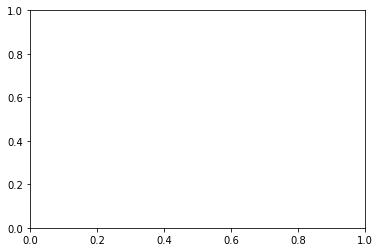

In [15]:
plt.plot(solution['t'], solution['y'])